In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
        
IMAGE_SIZE = 224

4 Physical GPUs, 1 Logical GPUs


In [2]:
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

In [3]:
img_name_list = []
caption_list = []

with open('./words_captcha/spec_train_val.txt') as fh:
    for line in fh:
        image_name, caption = line.strip().split()
        img_name_list.append(f'./words_captcha/{image_name}.png')
        caption_list.append('<start> ' + ' '.join(caption) + ' <end>')
        
# Only first 120,000 images have labels

test_img_name = set(glob(f'./words_captcha/*.png')) - set(img_name_list)
img_name_list += sorted(test_img_name)

print(img_name_list[0])
print(caption_list[0])

./words_captcha/a0.png
<start> t h u s <end>


In [4]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(caption_list)
caption_seq = tokenizer.texts_to_sequences(caption_list)

caption_seq = tf.keras.preprocessing.sequence.pad_sequences(caption_seq, padding='post')
max_length = len(caption_seq[0])

print(caption_list[0])
print(caption_seq[0])

<start> t h u s <end>
[ 2  9 18 17  6  3  0]


In [5]:
img_name_train = img_name_list[:100000]
img_name_valid = img_name_list[100000:120000]

caption_seq_train = caption_seq[:100000]
caption_seq_valid = caption_seq[100000:]

img_name_test = img_name_list[120000:]
caption_seq_test = caption_seq[120000:]

In [6]:
BATCH_SIZE = 32 # 100 is a suck number
BUFFER_SIZE = 5000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE

In [7]:
def load_image(image_path, caption):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    # img = tf.keras.applications.inception_v3.preprocess_input(img)
    image = tf.keras.applications.efficientnet.preprocess_input(img)
    return image, caption

In [8]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, caption_seq_train))\
                               .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .shuffle(BUFFER_SIZE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(tf.data.experimental.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((img_name_valid, caption_seq_valid))\
                               .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
image_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

feature_extractor = tf.keras.Model(new_input, hidden_layer)

In [10]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [11]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [12]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [13]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [15]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [16]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

ckpt_manager.restore_or_initialize()

In [17]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []
valid_plot = []

In [18]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    batch_size = img_tensor.shape[0]
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    hidden = decoder.reset_state(batch_size=batch_size)

    with tf.GradientTape() as tape:
        #  Instead of prestore the features into npy file, we called the feature_extractor directly (Easier to implement lol)
        features = feature_extractor(img_tensor, True)
        features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
        features = encoder(features)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = feature_extractor.trainable_variables + encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [19]:
from tqdm import tqdm

In [20]:
def predict(img_tensor):
    batch_size = img_tensor.shape[0]
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)

    hidden = decoder.reset_state(batch_size=batch_size)
    
    features = feature_extractor(img_tensor)
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    features = encoder(features)


    result = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    
    for i in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        
        predicted_id = tf.argmax(predictions, axis=1).numpy()
        dec_input = tf.expand_dims(predicted_id, 1)
        result = tf.concat([result, predicted_id.reshape((batch_size, 1))], axis=1)

    return result

In [21]:
def build_output(args):
    results = []
    for i in args:
        result = ""
        for s in i[1:]:
            if s == tokenizer.word_index["<end>"]:
                break
            else :
                result += tokenizer.index_word[s]
        results.append(result)
    return results

In [22]:
def evaluate(dataset_valid):
    total = 0
    correct = 0
    for img_tensor, target in dataset_valid:
        
        pred_list = build_output(predict(img_tensor).numpy())
        real_list = build_output(target.numpy())
        
        # total += min(len(pred_list), len(real_list))
        # correct += sum([1 for pred, real in zip(pred_list, real_list) if pred == real]) 
        
        if(pred_list == real_list):
            correct += 1
        total += 1

    return correct / total

In [23]:
EPOCHS = 100
start = time.time()
for epoch in range(start_epoch, EPOCHS):
    
    total_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(dataset_train), total=num_steps):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

    loss_plot.append(total_loss / num_steps)
    
    accuracy = evaluate(dataset_valid)
    valid_plot.append(accuracy)
    
    ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} Valid {:.3f}'.format(epoch + 1,
                                         total_loss/num_steps, accuracy))
    
    if(accuracy >= 0.90):
        break
    
print ('Time taken for {} epoch {} sec\n'.format(EPOCHS, time.time() - start))

100%|██████████| 3125/3125 [05:15<00:00,  9.90it/s]


Epoch 1 Loss 0.628039 Valid 0.037


100%|██████████| 3125/3125 [05:02<00:00, 10.32it/s]


Epoch 2 Loss 0.046461 Valid 0.256


100%|██████████| 3125/3125 [05:02<00:00, 10.33it/s]


Epoch 3 Loss 0.022519 Valid 0.214


100%|██████████| 3125/3125 [05:03<00:00, 10.29it/s]


Epoch 4 Loss 0.014721 Valid 0.518


100%|██████████| 3125/3125 [05:03<00:00, 10.30it/s]


Epoch 5 Loss 0.010567 Valid 0.594


100%|██████████| 3125/3125 [05:03<00:00, 10.31it/s]


Epoch 6 Loss 0.008164 Valid 0.573


100%|██████████| 3125/3125 [05:02<00:00, 10.33it/s]


Epoch 7 Loss 0.006810 Valid 0.662


100%|██████████| 3125/3125 [05:02<00:00, 10.33it/s]


Epoch 8 Loss 0.005623 Valid 0.642


100%|██████████| 3125/3125 [05:01<00:00, 10.35it/s]


Epoch 9 Loss 0.005072 Valid 0.710


100%|██████████| 3125/3125 [05:03<00:00, 10.29it/s]


Epoch 10 Loss 0.004418 Valid 0.755


100%|██████████| 3125/3125 [05:03<00:00, 10.29it/s]


Epoch 11 Loss 0.004095 Valid 0.768


100%|██████████| 3125/3125 [05:03<00:00, 10.30it/s]


Epoch 12 Loss 0.003533 Valid 0.773


100%|██████████| 3125/3125 [05:03<00:00, 10.29it/s]


Epoch 13 Loss 0.003295 Valid 0.827


100%|██████████| 3125/3125 [05:01<00:00, 10.35it/s]


Epoch 14 Loss 0.002949 Valid 0.726


100%|██████████| 3125/3125 [05:01<00:00, 10.36it/s]


Epoch 15 Loss 0.002860 Valid 0.840


100%|██████████| 3125/3125 [05:02<00:00, 10.34it/s]


Epoch 16 Loss 0.002688 Valid 0.634


100%|██████████| 3125/3125 [05:03<00:00, 10.31it/s]


Epoch 17 Loss 0.002365 Valid 0.845


100%|██████████| 3125/3125 [05:01<00:00, 10.36it/s]


Epoch 18 Loss 0.002445 Valid 0.850


100%|██████████| 3125/3125 [05:02<00:00, 10.33it/s]


Epoch 19 Loss 0.002091 Valid 0.835


100%|██████████| 3125/3125 [05:03<00:00, 10.29it/s]


Epoch 20 Loss 0.002322 Valid 0.875


100%|██████████| 3125/3125 [05:03<00:00, 10.31it/s]


Epoch 21 Loss 0.001884 Valid 0.866


100%|██████████| 3125/3125 [05:03<00:00, 10.30it/s]


Epoch 22 Loss 0.001734 Valid 0.886


100%|██████████| 3125/3125 [05:02<00:00, 10.32it/s]


Epoch 23 Loss 0.001742 Valid 0.878


100%|██████████| 3125/3125 [05:04<00:00, 10.28it/s]


Epoch 24 Loss 0.001806 Valid 0.848


100%|██████████| 3125/3125 [05:03<00:00, 10.28it/s]


Epoch 25 Loss 0.001674 Valid 0.814


100%|██████████| 3125/3125 [05:03<00:00, 10.31it/s]


Epoch 26 Loss 0.001599 Valid 0.864


100%|██████████| 3125/3125 [05:03<00:00, 10.31it/s]


Epoch 27 Loss 0.001469 Valid 0.909
Time taken for 100 epoch 10666.579244375229 sec



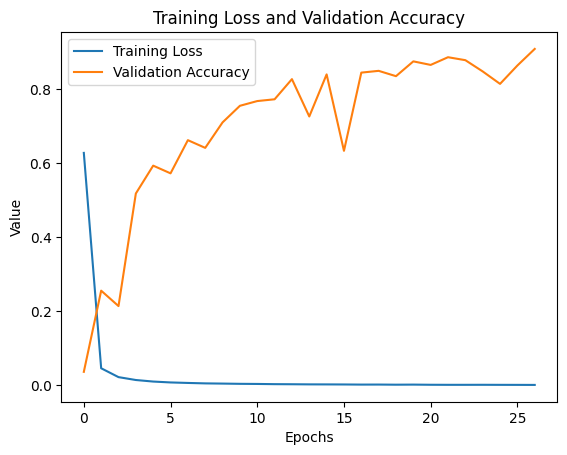

In [24]:
plt.plot(loss_plot, label='Training Loss')
plt.plot(valid_plot, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title('Training Loss and Validation Accuracy')
plt.legend()
plt.show()

#### Validation

#### Predictions over test set

In [25]:
# ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
#                            encoder=encoder,
#                            decoder=decoder,
#                            optimizer=optimizer)

In [26]:
# ckpt.restore('./checkpoints/train/ckpt-33')

In [27]:
score = evaluate(dataset_valid)
print(f'Final Validation Accuracy: {score:.3f}')

Final Validation Accuracy: 0.909


In [28]:
def map_test(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    # img = tf.keras.applications.inception_v3.preprocess_input(img)
    image = tf.keras.applications.efficientnet.preprocess_input(img)
    return image, image_path

In [29]:
dataset_test = tf.data.Dataset.from_tensor_slices((img_name_test))\
                              .map(map_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                              .batch(BATCH_SIZE)\
                              .prefetch(tf.data.experimental.AUTOTUNE)

In [30]:
with open('./Lab12-2_111062201.txt', 'w') as fh:
    for img_tensor, img_path in tqdm(dataset_test):
        pred_list = build_output(predict(img_tensor).numpy())
        for path, pred in zip(img_path, pred_list):
            img_name = re.search(r'(\w+)\.png', path.numpy().decode()).group(1)
            fh.write(f'{img_name} {pred}\n')

100%|██████████| 625/625 [01:35<00:00,  6.55it/s]


#### Report

For the pre-trained feature extractor, I used the EfficinetNetB0 model provided by keras.
To make the input image compatible with the model, I resized the image to 224x224 and used the preprocess_input function provided by the model.

As for training, select Adam as the optimizer (with learning rate = 1e-4) and SparseCategoricalCrossentropy as the loss function.

I trained the model for 27 epochs with a batch size of 32. ( Actually, since the accuracy curve is not convex, so I early stopped the training at 27 epochs.)
In addition, I suspect the reason why the accuracy curve isn't convex is that we calculate the accuracy based on the whole correct strings, but not based on the error rate of each single character, so the model might not hundred percently approach the correct answer.

I had tried to use the EfficientNetV2L as what we had done on competition 2 before, but I just keep getting OOM.

Also, I tried to set batch_size to 100 as  default, but it turns out the model is not converged too well. So I set the batch_size to MAGIC NUMBER 32.